# Optimize parameters of reduced morphology model 

Reduction method is Marasco method, 7 folding passes.

In [1]:
# Enable interactive plots with backend 'notebook'
%matplotlib notebook

# Enable connecting with ipyton console --existing
# %connect_info

# print code version (hash of checked out version)
!git log -1

# print date and time of script execution
import datetime
print("\nNotebook executed at at {} in following directory:".format(datetime.datetime.now()))
%cd ..
%pwd

commit 8cb10a93f5ef55fec995fba3c5b9371e093b223a (HEAD -> nothreadsafe, origin/nothreadsafe)
Author: Lucas Koelman <lucas.koelman@gmail.com>
Date:   Sat Oct 7 16:23:43 2017 +0100

    Add ephys protocol extension class to plug in shared protocol functions

Notebook executed at at 2017-10-09 13:15:00.043547 in following directory:
/home/luye/workspace/bgcellmodels/GilliesWillshaw


u'/home/luye/workspace/bgcellmodels/GilliesWillshaw'

## Notes for running optimization

To run parallel optimization (individuals in population evaluated over many cores), the ipyprallel module can be used. To use ipyparallel you must start a controller and a number of engine (worker) instances before starting ipython (see http://ipyparallel.readthedocs.io/en/latest/intro.html), e.g:

```bash
ipcluster start -n 6
```

, where the -n argument is the number of workers / cores.
	
Make sure that Hoc can find the .hoc model files by either executing above command in the directory containing those files, or adding the relevant directories to the environment variable `$HOC_LIBRARY_PATH` (this could also be done in 
your protocol or cellmodel script using `os.environ["HOC_LIBRARY_PATH"]`)

## Run optimization

Optimize parameters of reduced model. Passive parameters should be fitted first and set in the module file. Parameters to optimize, stimulation protocols to use for evaluation (objective function), and electrophysiological features extracted from the protocol responses can be set in following modules:

```python
optimize.bpop_parameters_stn
optimize.bpop_protocols_stn
optimize.bpop_features_stn
```

In [2]:
# Import our optimization modules
from optimize.bpop_cellmodels import StnReducedModel
from optimize.bpop_optimize_stn import *

# Choose model we want to optimize
cell_model = StnReducedModel(
                name        = 'StnFolded',
                fold_method = 'marasco',
                num_passes  = 7)

# Maximum number of generations in optimization
num_generations = 10

# Checkpoints: for each generation save [population, generation, parents, halloffame, history, logbook, rndstate]
checkpoints_file = '/home/luye/cloudstore_m/simdata/marasco_folding/opt_marasco7pass_checkpoints2.pkl'

# Make optimisation
optimisation, opt_data = make_optimisation(
                            red_model = cell_model, 
                            parallel = True,
                            export_locals = False)

bluepyopt.ephys.efeatures:DEBUG:Calculated value for CLAMP_REBOUND.min_AHP_values: -61.2351049487 @efeatures.py:177
bpop_ext:DEBUG:Calculated value for CLAMP_REBOUND.Victor_Purpura_distance: [ 511.   517.5  522.2  528.   533.8  539.9  546.4  552.9  559.5  566.1
  572.8  579.6  586.4  593.3  600.3  607.7  617. ] @bpop_efeatures.py:238
bluepyopt.ephys.efeatures:DEBUG:Calculated value for CLAMP_REBOUND.ISI_CV: 0.14756131579 @efeatures.py:177
bluepyopt.ephys.efeatures:DEBUG:Calculated value for CLAMP_REBOUND.adaptation_index: 0.0119738183039 @efeatures.py:177
bluepyopt.ephys.efeatures:DEBUG:Calculated value for CLAMP_REBOUND.Spikecount: 17.0 @efeatures.py:177
bluepyopt.ephys.efeatures:DEBUG:Calculated value for MIN_SYN_BURST.min_AHP_values: -64.4950936613 @efeatures.py:177
bpop_ext:DEBUG:Calculated value for MIN_SYN_BURST.Victor_Purpura_distance: [   3.8   10.    15.5   21.6   27.6   33.6   39.8   45.9   52.1   58.3
   64.6   70.8   77.1   83.4   89.8   96.2  102.5  108.9  115.4  121.8
  1

Ready for parallel execution on folowing hosts: lucas-thinkstation


In [3]:
# Run optimisation
final_pop, hall_of_fame, logs, hist = optimisation.run(
                                        max_ngen = num_generations,
                                        cp_filename = checkpoints_file)

__main__:INFO:gen	nevals	avg    	std    	min    	max    
1  	10    	556.001	233.493	58.2774	707.809
2  	10    	599.153	281.831	58.2774	1334.8  @algorithms.py:136
__main__:DEBUG:Wrote checkpoint to /home/luye/cloudstore_m/simdata/marasco_folding/opt_marasco7pass_checkpoints2.pkl @algorithms.py:148
__main__:INFO:3  	10    	461.748	271.293	58.2774	702.665 @algorithms.py:136
__main__:DEBUG:Wrote checkpoint to /home/luye/cloudstore_m/simdata/marasco_folding/opt_marasco7pass_checkpoints2.pkl @algorithms.py:148
__main__:INFO:4  	10    	261.317	409.965	58.2774	1662    @algorithms.py:136
__main__:DEBUG:Wrote checkpoint to /home/luye/cloudstore_m/simdata/marasco_folding/opt_marasco7pass_checkpoints2.pkl @algorithms.py:148
__main__:INFO:5  	10    	93.9362	127.889	39.1439	649.292 @algorithms.py:136
__main__:DEBUG:Wrote checkpoint to /home/luye/cloudstore_m/simdata/marasco_folding/opt_marasco7pass_checkpoints2.pkl @algorithms.py:148
__main__:INFO:6  	10    	83.5475	139.067	24.835 	686.957 @algorith

## Analyze optimization results

We want to know how our individuals (candidate parameter sets) evolved during the optimization, and potentially how their responses look.

In [4]:
# OPTIONAL: reload previous results from checkpoints file
# checkpoint = pickle.load(open(checkpoints_file, "r"))
# logs = checkpoint['logbook']

NameError: name 'pickle' is not defined

<IPython.core.display.Javascript object>


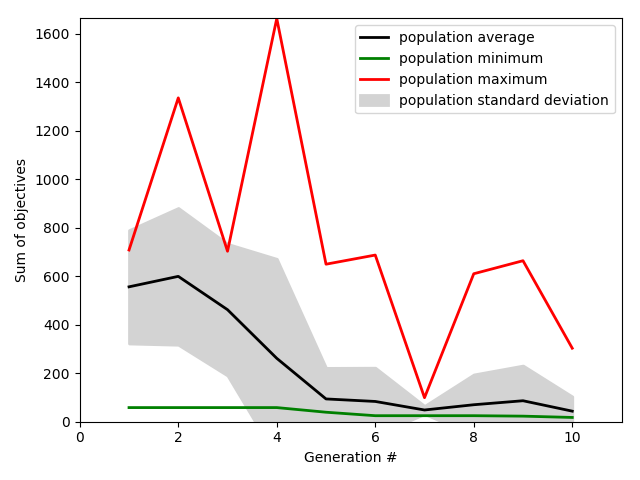

In [4]:
# Import our analysis modules
from optimize.bpop_analysis_stn import plot_log

# Plot evolution of fitness values
plot_log(logs)

## Evaluate / Validate optimization results

We want to know how our optimized model performs under other stimulation protocols that were not part of the objective function. This is a form of cross-validation.

### Plot parameters and how they evolved

In [5]:
# %load_ext autoreload
# %autoreload 2

from optimize.bpop_analysis_stn import (
    plot_responses,
    plot_fitness_scores,
    plot_diversity,
)

# Retrieve optimisation variables
# evaluator = opt_data['evaluator']
# ephys_protocols = opt_data['ephys_protocols']
evaluator = optimisation.evaluator
ephys_protocols = optimisation.evaluator.fitness_protocols

In [7]:
import pprint
pp = pprint.PrettyPrinter(indent=2)

# Print fittest individual (best parameter set)
best_params = evaluator.param_dict(hall_of_fame[0])
print(pp.pprint(best_params))

{ 'gcaL_HVA_dend_scale': 2.198397934257813,
  'gcaN_HVA_dend_scale': 4.883377860521972,
  'gcaT_CaT_dend_scale': 1.4777489914332969,
  'gk_Ih_dend_scale': 9.026577539345528,
  'gk_sKCa_dend_scale': 9.573377927367712,
  'gna_NaL_dend_scale': 7.528532199224967}
None


<IPython.core.display.Javascript object>


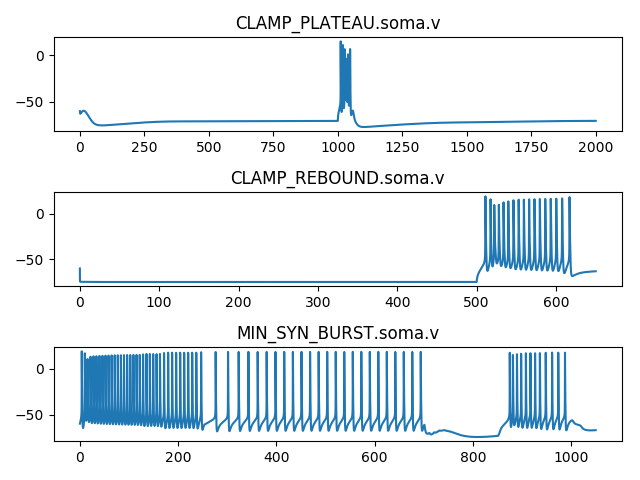

1  
loading STh cell data structures...
 
1 Creating STh Neurons

22   2 trees
  loaded tree 0 (23 branches)
  loaded tree 1 (11 branches)
loading linear+uniform conductances
0.0001 0.001 Skipping soma


bluepyopt.ephys.mechanisms:DEBUG:Inserted GLUsyn at ['zipF_zipE_zipD_SThcell0dend01(0.9375)', 'zipG_zipF_zipE_zipD_SThcell0dend02(1)', 'zipG_zipF_zipE_zipD_SThcell0dend02(1)', 'zipG_zipF_zipE_zipD_SThcell0dend01(1)']  @mechanisms.py:303
bluepyopt.ephys.mechanisms:DEBUG:Inserted GABAsyn at ['SThcell[0].dend0[2](0.75)']  @mechanisms.py:303
bpop_ext:DEBUG:Scaled gna_NaL in ['dendritic'] by factor 7.52853219922 @bpop_extensions.py:86
bpop_ext:DEBUG:Scaled gk_Ih in ['dendritic'] by factor 9.02657753935 @bpop_extensions.py:86
bpop_ext:DEBUG:Scaled gk_sKCa in ['dendritic'] by factor 9.57337792737 @bpop_extensions.py:86
bpop_ext:DEBUG:Scaled gcaT_CaT in ['dendritic'] by factor 1.47774899143 @bpop_extensions.py:86
bpop_ext:DEBUG:Scaled gcaL_HVA in ['dendritic'] by factor 2.19839793426 @bpop_extensions.py:86
bpop_ext:DEBUG:Scaled gcaN_HVA in ['dendritic'] by factor 4.88337786052 @bpop_extensions.py:86


Setting in vitro parameters based on Bevan & Wilson (1999)


bpop_ext:DEBUG:Adding space clamp to somatic[0](0.5) with durations [0, 0, 500], and amplitudes [0, 0, -75] @bpop_extensions.py:220
bluepyopt.ephys.recordings:DEBUG:Adding compartment recording of v at somatic[0](0.5) @recordings.py:89
bluepyopt.ephys.simulators:DEBUG:Running Neuron simulator 650 ms, with dt=0.025 @simulators.py:133
bluepyopt.ephys.simulators:DEBUG:Neuron simulation finished @simulators.py:147


1  
loading STh cell data structures...
 
1 Creating STh Neurons

22   2 trees
  loaded tree 0 (23 branches)
  loaded tree 1 (11 branches)
loading linear+uniform conductances
0.0001 0.001 Skipping soma


bluepyopt.ephys.mechanisms:DEBUG:Inserted GLUsyn at ['zipF_zipE_zipD_SThcell0dend01(0.9375)', 'zipG_zipF_zipE_zipD_SThcell0dend02(1)', 'zipG_zipF_zipE_zipD_SThcell0dend02(1)', 'zipG_zipF_zipE_zipD_SThcell0dend01(1)']  @mechanisms.py:303
bluepyopt.ephys.mechanisms:DEBUG:Inserted GABAsyn at ['SThcell[0].dend0[2](0.75)']  @mechanisms.py:303
bpop_ext:DEBUG:Scaled gna_NaL in ['dendritic'] by factor 7.52853219922 @bpop_extensions.py:86
bpop_ext:DEBUG:Scaled gk_Ih in ['dendritic'] by factor 9.02657753935 @bpop_extensions.py:86
bpop_ext:DEBUG:Scaled gk_sKCa in ['dendritic'] by factor 9.57337792737 @bpop_extensions.py:86
bpop_ext:DEBUG:Scaled gcaT_CaT in ['dendritic'] by factor 1.47774899143 @bpop_extensions.py:86
bpop_ext:DEBUG:Scaled gcaL_HVA in ['dendritic'] by factor 2.19839793426 @bpop_extensions.py:86
bpop_ext:DEBUG:Scaled gcaN_HVA in ['dendritic'] by factor 4.88337786052 @bpop_extensions.py:86
bpop_ext:DEBUG:Set aCSF concentrations. @bpop_protocols_stn.py:388
bluepyopt.ephys.recordings:D

<IPython.core.display.Javascript object>


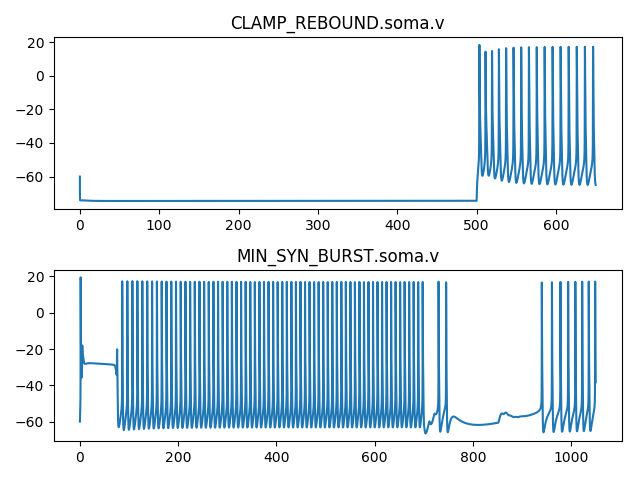

In [8]:
# Plot full model responses
full_responses = load_proto_responses(PROTO_RESPONSES_FILE)
full_resp = {}
for stimproto, responses in full_responses.iteritems():
    full_resp.update(responses)
plot_responses(full_resp)

# Plot responses of best parameters
best_responses = evaluator.run_protocols(protocols=ephys_protocols.values(), param_values=best_params)
plot_responses(best_responses)

In [ ]:
# Plot fitness (objective) scores
objectives = optimisation.evaluator.fitness_calculator.calculate_scores(best_responses)
plot_fitness_scores(objectives)

In [ ]:
# Plot diversity of parameters
plot_diversity(optimisation, checkpoints_file, optimisation.evaluator.param_names)


In [ ]:
# TODO: use StnModuleEvaluator to evaluate other protocols
#    - first uniformize interface for setting up model and protocols
#    - also implement evaluation metrics (distance ephys)